In [98]:
from pyDOE import lhs
#We will use Latin Hypercube Sampling from this library


In [99]:
import torch                           # Pytorch
import torch.autograd as autograd      # computation graph
from torch import Tensor
import torch.nn as nn                  # neural networks
import torch.optim as optim            # optimizers
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
import time, sys
from tqdm.notebook import tqdm_notebook


#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("The neural network will be trainied on",device)

if device == 'cuda':
    print(torch.cuda.get_device_name())

%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}


The neural network will be trainied on cuda


In [100]:
def plot3D(x,t,y):
    x_plot =x.squeeze(1)
    t_plot =t.squeeze(1)
    X,T= torch.meshgrid(x_plot,t_plot,indexing='ij')
    u_xt = y
    fig = plt.figure()
    ax=fig.subplots(1,1)
    cp = ax.contourf(T,X,u_xt,20,cmap=cm.rainbow) #)levels = np.linspace(-1.0,1.0,12))
    fig.colorbar(cp) # Add a colorbar to a plot
    ax.set_title('u')
    ax.set_xlabel('t')
    ax.set_ylabel('x')
    plt.show()
    ax = plt.axes(projection='3d')
    surf = ax.plot_surface(T.numpy(), X.numpy(), u_xt.numpy(),cmap=cm.rainbow, antialiased=False)
    ax.set_xlabel('t')
    ax.set_ylabel('x')
    ax.set_zlabel('u')
    #ax.set_zlim3d(-1, 1)
    plt.show()


In [ ]:
#x∈[0,2]
x_min=0
x_max=2

#t∈[0,0.48]
t_min=0
t_max=1.0

viscosity = 0.01/np.pi # Given


#Discretization points for x and t

total_points_x=1001
total_points_t=2000

dx = (x_max-x_min)/(total_points_x-1)

dt = (t_max-t_min)/(total_points_t)


dx,dt, dt/dt


(0.002, 0.0006, 1.0)

In [102]:
#Implementing Finite Difference Method to solve the 1D Diffusion Equation

def u_fem(x,t):
    un = torch.ones(total_points_x)
    rec = torch.zeros([total_points_x, total_points_t])

    for j in tqdm_notebook(range(total_points_t)):

        un = u.clone()

        for i in range(1,total_points_x-1):
            rec[i,j] = u[i]
            u[i] = un[i] - un[i] * dt/dx * (un[i]-un[i-1])  + viscosity * (dt/dx**2) * (un[i+1]- 2*un[i] + un[i-1])
            if np.isnan(u[i]):
              print(i, j, u[i-1])
              break

    return u, rec


In [103]:
x = torch.linspace(x_min, x_max, total_points_x)


In [104]:
u = torch.from_numpy(np.sin(np.pi*x.numpy()))


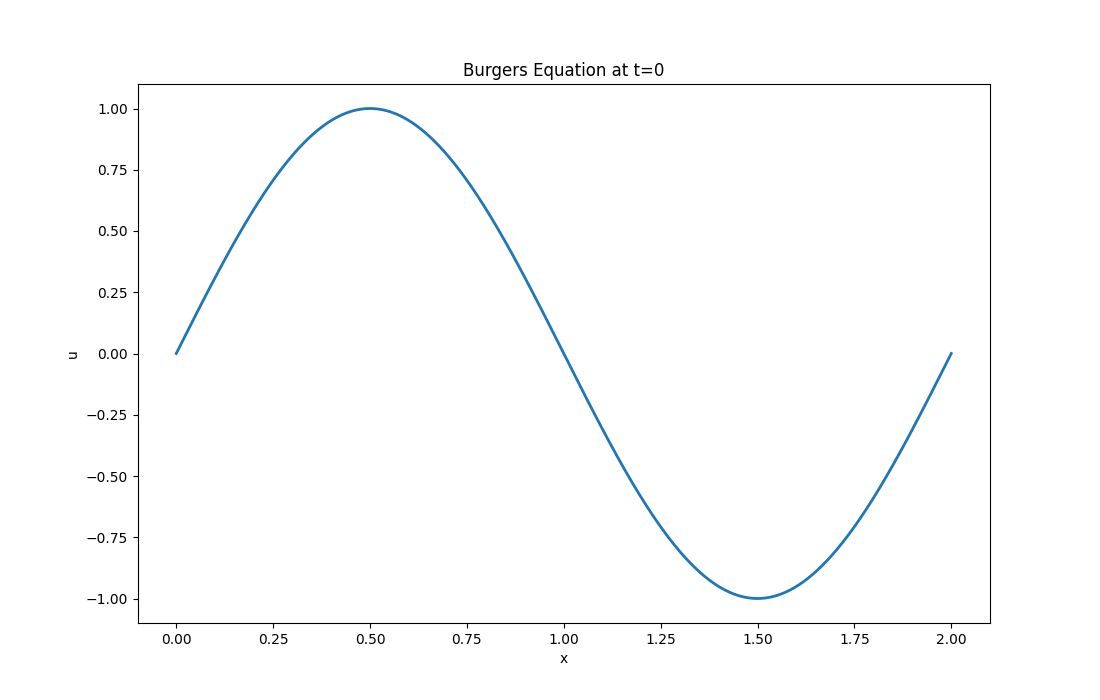

In [105]:
u_plot = u.clone()
plt.figure(figsize=(11, 7), dpi= 100)
plt.plot(x, u_plot, lw=2)
plt.xlabel('x')
plt.ylabel('u')
plt.title('Burgers Equation at t=0');


In [106]:
# Creating same amount of grid lattice as FDM

x = torch.linspace(x_min, x_max, total_points_x).view(-1,1)
t = torch.linspace(t_min, t_max, total_points_t).view(-1,1)
x.shape, t.shape


(torch.Size([1001, 1]), torch.Size([1000, 1]))

In [107]:
# Computing Finite Difference solution for u

print("Running Finite Difference Method...")
u_final, u_fem_2D = u_fem(x,t)

assert u_fem_2D.shape == torch.Size([total_points_x, total_points_t]),f"Expected [{total_points_x},{total_points_t}], got {u_fem_2D.shape}"
print("Completed successfully!")


Running Finite Difference Method...


  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\Admin\AppData\Local\Temp\ipykernel_16944\4115309637.py:14: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  if np.isnan(u[i]):


Completed successfully!


In [108]:
X, T = torch.meshgrid(x.squeeze(1),t.squeeze(1), indexing='ij')


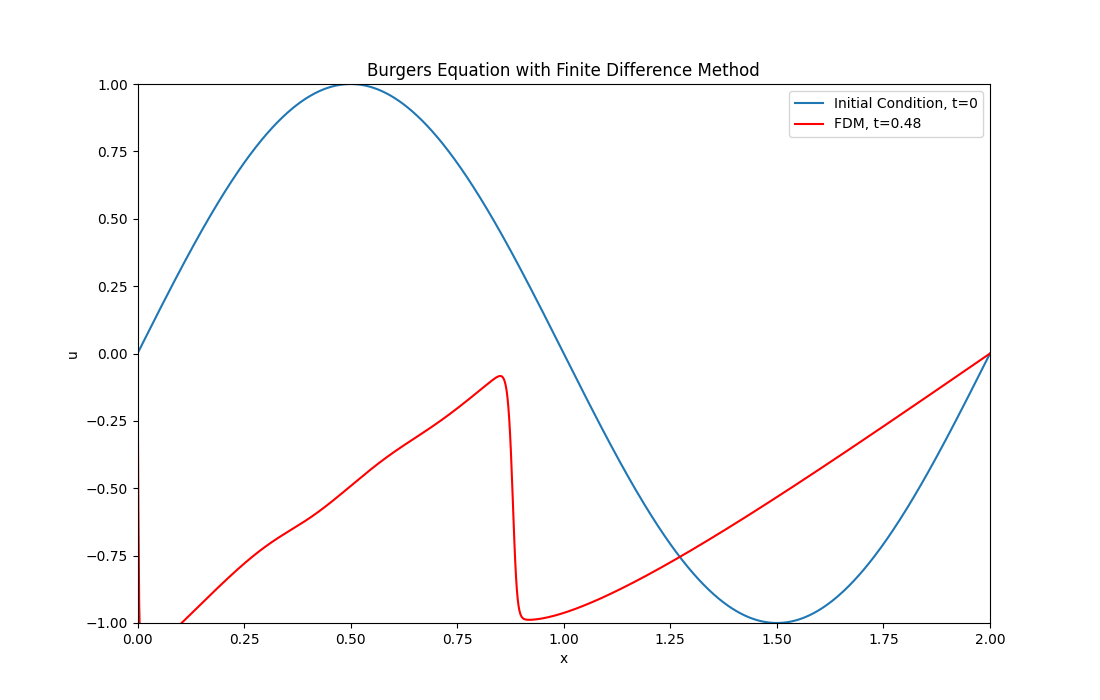

In [109]:
plt.figure(figsize=(11, 7), dpi= 100)
plt.plot(x, u_plot, label="Initial Condition, t=0")
plt.plot(x, u_final, 'r',label="FDM, t=0.48")
plt.xlim([x_min,x_max])
plt.ylim([-1, 1])
plt.legend()
plt.xlabel('x')
plt.ylabel('u')
plt.title('Burgers Equation with Finite Difference Method');
plt.show()


FDM Solution Visualization


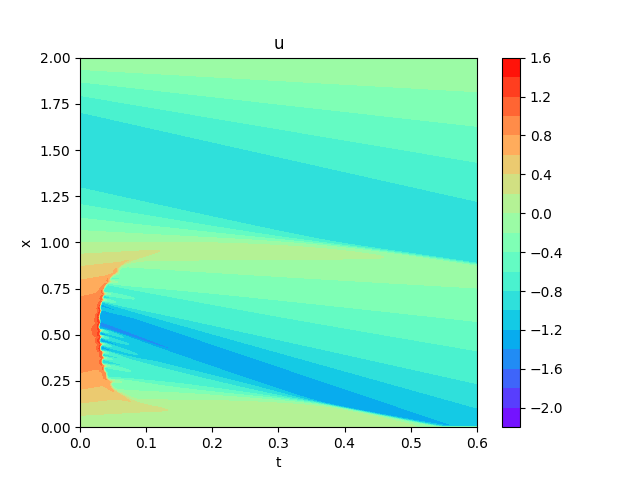

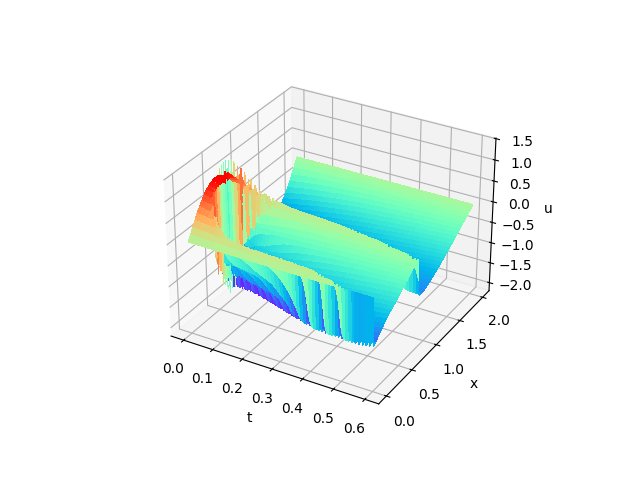

In [110]:
print("FDM Solution Visualization")
plot3D(x,t,u_fem_2D)


In [111]:
# Creating same amount of grid lattice as FDM
x = torch.linspace(x_min, x_max, total_points_x).view(-1,1)
t = torch.linspace(t_min, t_max, total_points_t).view(-1,1)
x.shape, t.shape


(torch.Size([1001, 1]), torch.Size([1000, 1]))

In [112]:
X, T = torch.meshgrid(x.squeeze(1),t.squeeze(1), indexing='ij') #same as FDM
X.shape, T.shape


(torch.Size([1001, 1000]), torch.Size([1001, 1000]))

In [113]:
left_X = torch.hstack((X[:,0][:,None], T[:,0][:,None])) #horizontal stacking to create X, T dataset


In [114]:
left_U = torch.sin(np.pi*left_X[:,0]).unsqueeze(1) #initial condition is a sine wave
left_U.shape


torch.Size([1001, 1])

In [115]:
# BC at x_min
bottom_X = torch.hstack((X[0,:][:,None],T[0,:][:,None]))
top_X = torch.hstack((X[-1,:][:,None],T[-1,:][:,None]))

bottom_U = torch.zeros(bottom_X.shape[0],1)
top_U = torch.zeros(top_X.shape[0],1)

bottom_X.shape


torch.Size([1000, 2])

In [116]:
X_bc = torch.vstack([bottom_X, top_X])
U_bc = torch.vstack([bottom_U, top_U])

X_bc.shape


torch.Size([2000, 2])

In [117]:
N_ic = 1000
N_bc = 1000 #Number of points on IC and BC
N_pde = 30000 #Number of points on PDE domain (Collocation Points)

#Now we will sample N_bc points at random
#from the X_train, U_train dataset

idx = np.random.choice(X_bc.shape[0],N_bc, replace=False)
X_bc_samples = X_bc[idx,:]
U_bc_samples = U_bc[idx,:]

idx = np.random.choice(left_X.shape[0],N_ic, replace=False)
X_ic_samples = left_X[idx,:]
U_ic_samples = left_U[idx,:]

#The boundary conditions will not change.
#Hence, these U values can be used as supervised labels during training

#For PDE collocation points, we will generate new X_train_pde dataset
#We do not know U(X,T) for these points

#Lets get the entire X,T dataset in a format suitable for Neural Network
#We will later use this for testing NN as well. So, lets call this x_test for convenience

x_test = torch.hstack((X.transpose(1,0).flatten()[:,None],
                       T.transpose(1,0).flatten()[:,None]))

#We need column major flattening to simlulte time-marching. Hence the transpose(1,0) or simply use .T

#we will use U generated from FEM as our u_test
#We will use u_test later in the process for calculating NN performance

u_test = u_fem_2D.transpose(1,0).flatten()[:,None]
x_test.shape


torch.Size([1001000, 2])

In [118]:
x_test.shape


torch.Size([1001000, 2])

In [119]:
#lower and upper bounds of x_test
lb = x_test[0]
ub = x_test[-1]
lb,ub


(tensor([0., 0.]), tensor([2.0000, 0.6000]))

In [120]:
#Sampling (X,T) domain using LHS
lhs_samples = lhs(2,N_pde)
#2 since there are 2 variables in X_train, [x,t]
lhs_samples.shape


(30000, 2)

In [121]:
X_train_lhs = lb + (ub-lb)*lhs_samples
X_train_lhs.shape


C:\Users\Admin\AppData\Local\Temp\ipykernel_16944\752805534.py:1: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  X_train_lhs = lb + (ub-lb)*lhs_samples


torch.Size([30000, 2])

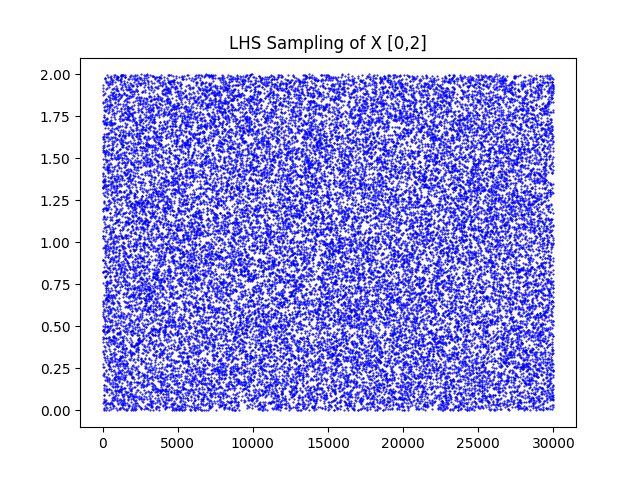

In [122]:
plt.plot(pd.DataFrame(X_train_lhs)[0], "bo", markersize=.5)
plt.title("LHS Sampling of X [0,2]")
plt.show()


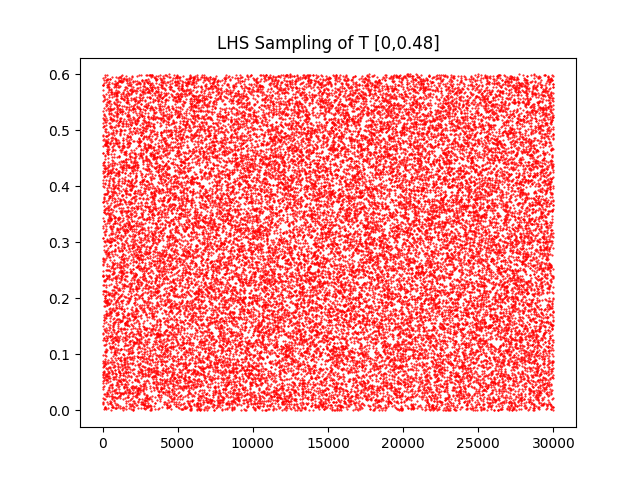

In [123]:
plt.plot(pd.DataFrame(X_train_lhs)[1], "ro", markersize=.5)
plt.title("LHS Sampling of T [0,0.48]")
plt.show()


In [124]:
X_train_final = torch.vstack((X_train_lhs, X_ic_samples, X_bc_samples))
X_train_final.shape


torch.Size([32000, 2])

In [29]:
#Lets define a u_NN

class u_NN(nn.Module):

    def __init__(self, layers_list):

        super().__init__()

        self.depth = len(layers_list)

        self.loss_function = nn.MSELoss(reduction="mean")

        self.activation = nn.Tanh() #This is important, ReLU wont work

        self.linears = nn.ModuleList([nn.Linear(layers_list[i],layers_list[i+1]) for i in range(self.depth-1)])

        for i in range(self.depth-1):

          nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0) #xavier normalization of weights

          nn.init.zeros_(self.linears[i].bias.data) #all biases set to zero

    def Convert(self, x): #helper function

        if torch.is_tensor(x) !=True:
            x = torch.from_numpy(x)
        return x.float().to(device)

    def forward(self, x):

        a = self.Convert(x)

        for i in range(self.depth-2):
            z = self.linears[i](a)
            a = self.activation(z)

        a = self.linears[-1](a)

        return a

    def loss_bc(self, x_bc, u_bc):
        #This is similar to a Supervised Learning

        l_bc = self.loss_function(self.forward(self.Convert(x_bc)), self.Convert(u_bc)) #L2 loss

        return l_bc

    def loss_ic(self, x_ic, u_ic):
        #This is similar to a Supervised Learning

        l_ic = self.loss_function(self.forward(self.Convert(x_ic)), self.Convert(u_ic)) #L2 loss

        return l_ic

    def loss_pde(self, x_pde):
        # We will pass x_train_final here.
        # Note that we do not have U_pde (labels) here to calculate loss. This is not Supervised Learning.
        # Here we want to minimize the residues. So, we will first calculate the residue and then minimize it to be close to zero.

        x_pde = self.Convert(x_pde)

        x_pde_clone = x_pde.clone() ##VERY IMPORTANT

        x_pde_clone.requires_grad = True #enable Auto Differentiation

        NN = self.forward(x_pde_clone) #Generates predictions from u_NN

        NNx_NNt = torch.autograd.grad(NN, x_pde_clone,self.Convert(torch.ones([x_pde_clone.shape[0],1])),retain_graph=True, create_graph=True)[0] #Jacobian of dx and dt

        NNxx_NNtt = torch.autograd.grad(NNx_NNt,x_pde_clone, self.Convert(torch.ones(x_pde_clone.shape)), create_graph=True)[0] #Jacobian of dx2, dt2

        NNxx = NNxx_NNtt[:,[0]] #Extract only dx2 terms

        NNt = NNx_NNt[:,[1]] #Extract only dt terms

        NNx = NNx_NNt[:,[0]] #Extract only dx terms

        # {(du/dt) = viscosity * (d2u/dx2)} is the pde and the NN residue will be {du_NN/dt - viscosity*(d2u_NN)/dx2} which is == {NNt - viscosity*NNxx}

        residue = NNt + self.forward(x_pde_clone)*(NNx) - (viscosity)*NNxx

        # The residues need to be zero (or as low as possible). We'll create an arrazy of Zeros and minimize the residue

        zeros = self.Convert(torch.zeros(residue.shape[0],1))

        l_pde = self.loss_function(residue, zeros) #L2 Loss

        return l_pde

    def total_loss(self, x_ic, u_ic, x_bc, u_bc, x_pde): #Combine both loss
        l_bc = self.loss_bc(x_bc, u_bc)
        l_ic = self.loss_ic(x_ic, u_ic)
        l_pde = self.loss_pde(x_pde)
        return l_bc + l_pde + l_ic #this HAS to be a scalar value for auto differentiation to do its thing.


In [30]:
#Parameters for u_NN




In [38]:
from torch.utils.data import DataLoader, TensorDataset


def train_pinn(hyperparams):
    EPOCHS = hyperparams['epochs']
    initial_lr = hyperparams['initial_lr']
    layers_list = hyperparams['layers_list']
    batch_size = hyperparams['batch_size']

    # Instantiate a model

    PINN = u_NN(layers_list).to(device)

    if hyperparams["optimizer"] == "Adam":
        optimizer = torch.optim.Adam(PINN.parameters(), lr=initial_lr,amsgrad=False)
    elif hyperparams["optimizer"] == "RMSprop":
        optimizer = torch.optim.RMSprop(PINN.parameters(), lr=initial_lr)
    else:
        optimizer = torch.optim.SGD(PINN.parameters(), lr=initial_lr)

    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=hyperparams['lr_decay'])

    history = pd.DataFrame(columns=["Epochs","Learning_Rate", "IC_Loss","BC_Loss","PDE_Loss","Total_Loss","Test_Loss"])

    X_dataloader = DataLoader(TensorDataset(X_train_final), batch_size=batch_size, shuffle=True)

    Epoch = []
    Learning_Rate = []
    IC_Loss = []
    BC_Loss = []
    PDE_Loss = []
    Total_Loss = []
    Test_Loss = []

    for i in tqdm_notebook(range(EPOCHS)):

        for batch in X_dataloader: #dummy loop for batch size
            loss = PINN.total_loss(X_ic_samples,U_ic_samples,X_bc_samples,U_bc_samples, X_train_final)
            optimizer.zero_grad()

            loss.backward()

            optimizer.step()
        

        if i%5 == 0: #print losses and step the exponential learning rate.
            l_ic = PINN.loss_ic(X_ic_samples,U_ic_samples)
            l_bc = PINN.loss_bc(X_bc_samples,U_bc_samples)
            l_pde = PINN.loss_pde(X_train_final)
            with torch.no_grad():
                test_loss = PINN.loss_bc(x_test,u_test) #Here we are using loss_bc method as a helper function to calculate L2 loss
                
                Epoch.append(i)
                Learning_Rate.append(scheduler.get_last_lr()[0])
                IC_Loss.append(l_ic.detach().cpu().numpy())
                BC_Loss.append(l_bc.detach().cpu().numpy())
                PDE_Loss.append(l_pde.detach().cpu().numpy())
                Total_Loss.append(loss.detach().cpu().numpy())
                Test_Loss.append(test_loss.detach().cpu().numpy())

                '''print(i,'\t',format(scheduler.get_last_lr()[0],".4E"),'\t',format(l_ic.detach().cpu().numpy(),".4E"),'\t',format(l_bc.detach().cpu().numpy(),".4E"),'\t',
                    format(l_pde.detach().cpu().numpy(),".4E"),'\t',format(loss.detach().cpu().numpy(),".4E"),'\t',format(test_loss.detach().cpu().numpy(),".4E"))'''

            scheduler.step()

    return PINN



In [79]:
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.base import BaseEstimator, RegressorMixin


hyperparams = {
    'epochs': [10],
    'initial_lr': [0.001, 0.005],
    'lr_decay': [0.985],
    'layers_list': [[2, 32, 64, 64, 32, 1], [2, 8, 16, 16, 8, 1]],
    'batch_size': [128, 64],
    'optimizer': ['Adam']  # Options: 'Adam', 'RMSprop', 'SGD'
}

param_grid = ParameterGrid(hyperparams)

df = []
for params in param_grid:
    print("Training with hyperparameters:", params)
    PINN_model = train_pinn(params)
    # Evaluate the model on the test set
    test_loss = PINN_model.total_loss(X_ic_samples, U_ic_samples, X_bc_samples, U_bc_samples, x_test).item()
    # Store results
    result = params.copy()
    result['test_loss'] = test_loss
    df.append(result)
df = pd.DataFrame(df)
print("\nAll results:")
print(df)

Training with hyperparameters: {'batch_size': 128, 'epochs': 10, 'initial_lr': 0.001, 'layers_list': [2, 32, 64, 64, 32, 1], 'lr_decay': 0.985, 'optimizer': 'Adam'}


  0%|          | 0/10 [00:00<?, ?it/s]

Training with hyperparameters: {'batch_size': 128, 'epochs': 10, 'initial_lr': 0.001, 'layers_list': [2, 8, 16, 16, 8, 1], 'lr_decay': 0.985, 'optimizer': 'Adam'}


  0%|          | 0/10 [00:00<?, ?it/s]

Training with hyperparameters: {'batch_size': 128, 'epochs': 10, 'initial_lr': 0.005, 'layers_list': [2, 32, 64, 64, 32, 1], 'lr_decay': 0.985, 'optimizer': 'Adam'}


  0%|          | 0/10 [00:00<?, ?it/s]

Training with hyperparameters: {'batch_size': 128, 'epochs': 10, 'initial_lr': 0.005, 'layers_list': [2, 8, 16, 16, 8, 1], 'lr_decay': 0.985, 'optimizer': 'Adam'}


  0%|          | 0/10 [00:00<?, ?it/s]

Training with hyperparameters: {'batch_size': 64, 'epochs': 10, 'initial_lr': 0.001, 'layers_list': [2, 32, 64, 64, 32, 1], 'lr_decay': 0.985, 'optimizer': 'Adam'}


  0%|          | 0/10 [00:00<?, ?it/s]

Training with hyperparameters: {'batch_size': 64, 'epochs': 10, 'initial_lr': 0.001, 'layers_list': [2, 8, 16, 16, 8, 1], 'lr_decay': 0.985, 'optimizer': 'Adam'}


  0%|          | 0/10 [00:00<?, ?it/s]

Training with hyperparameters: {'batch_size': 64, 'epochs': 10, 'initial_lr': 0.005, 'layers_list': [2, 32, 64, 64, 32, 1], 'lr_decay': 0.985, 'optimizer': 'Adam'}


  0%|          | 0/10 [00:00<?, ?it/s]

Training with hyperparameters: {'batch_size': 64, 'epochs': 10, 'initial_lr': 0.005, 'layers_list': [2, 8, 16, 16, 8, 1], 'lr_decay': 0.985, 'optimizer': 'Adam'}


  0%|          | 0/10 [00:00<?, ?it/s]


All results:
   batch_size  epochs  initial_lr             layers_list  lr_decay optimizer  \
0         128      10       0.001  [2, 32, 64, 64, 32, 1]     0.985      Adam   
1         128      10       0.001    [2, 8, 16, 16, 8, 1]     0.985      Adam   
2         128      10       0.005  [2, 32, 64, 64, 32, 1]     0.985      Adam   
3         128      10       0.005    [2, 8, 16, 16, 8, 1]     0.985      Adam   
4          64      10       0.001  [2, 32, 64, 64, 32, 1]     0.985      Adam   
5          64      10       0.001    [2, 8, 16, 16, 8, 1]     0.985      Adam   
6          64      10       0.005  [2, 32, 64, 64, 32, 1]     0.985      Adam   
7          64      10       0.005    [2, 8, 16, 16, 8, 1]     0.985      Adam   

   test_loss  
0   0.007414  
1   0.017398  
2   0.006238  
3   0.006511  
4   0.007491  
5   0.009854  
6   0.000705  
7   0.005153  


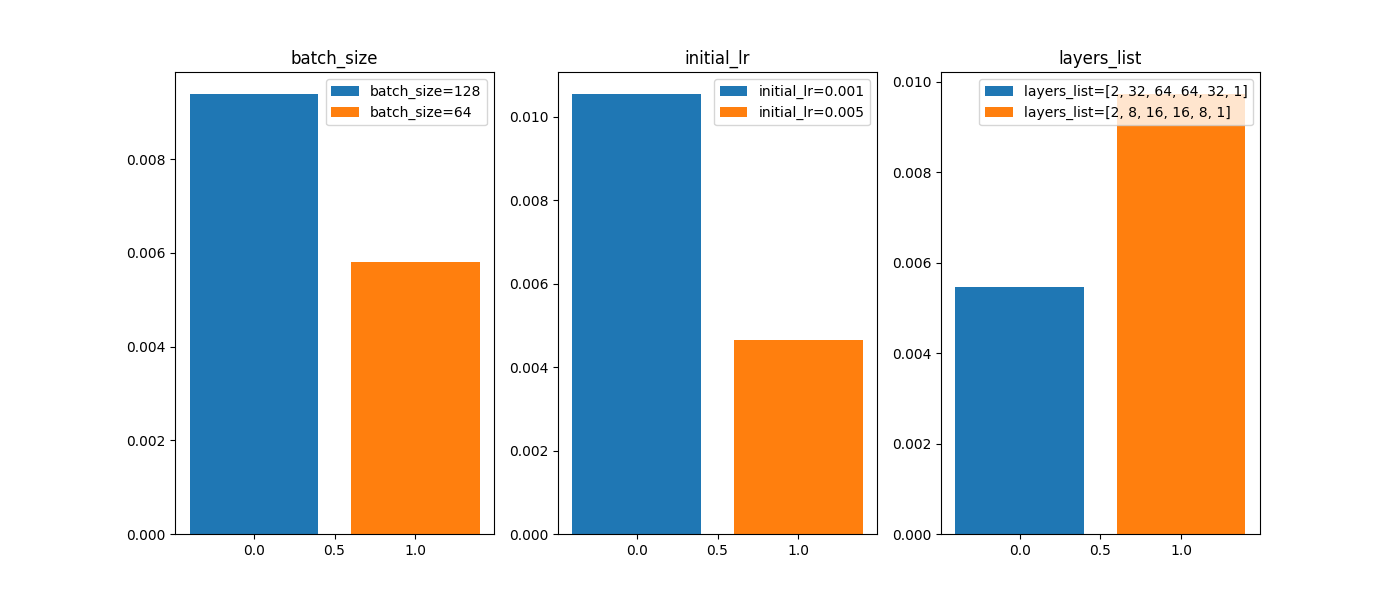

In [80]:
ax_n = 0
df_str = df.astype(str)
for column in df.columns[:-1]:
    values = df_str[column].unique()
    if values.size > 1:
        ax_n += 1

fig, axs = plt.subplots(1, ax_n, figsize=(14, 6))
j = 0
for i, column in enumerate(df.columns[:-1]):
    values = df_str[column].unique()
    
    if values.size > 1:
        ax = axs[j]
        k = 0
        for val in values:
            subset = df_str[df_str[column] == val]
            value = subset["test_loss"].astype(float).mean()
            ax.bar(k, value, label=f"{column}={val}")
            k += 1
        ax.set_title(f'{column}')
        ax.legend()
        j+=1

In [ ]:

def evaluate_pinn(PINN, x_test):
    with torch.no_grad():
        u_NN_predict = PINN(x_test)
        
    u_NN_2D = u_NN_predict.reshape(shape=[total_points_t,total_points_x]).transpose(1,0).detach().cpu()

    assert u_NN_2D.shape == torch.Size([total_points_x, total_points_t]),f"Expected [{total_points_x},{total_points_t}], got {u_NN_2D.shape}"
    RMSE = torch.sqrt(torch.mean(torch.square(torch.subtract(u_NN_2D,u_fem_2D))))

    print("The RMSE error between FDM and PINN is :",np.around(RMSE.item(),5))

In [81]:
PINN = train_pinn({
    'epochs': 50,
    'initial_lr': 0.005,
    'lr_decay': 0.990,
    'layers_list': [2, 32, 64, 64, 32, 1],
    'batch_size': 64,
    'optimizer': 'Adam'
})

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
#Reshapping y1 to be used in plot3d()



In [85]:
#Saving the model
torch.save(PINN, "./model.pth")


In [125]:
PINN = torch.load("./model.pth", weights_only=False)

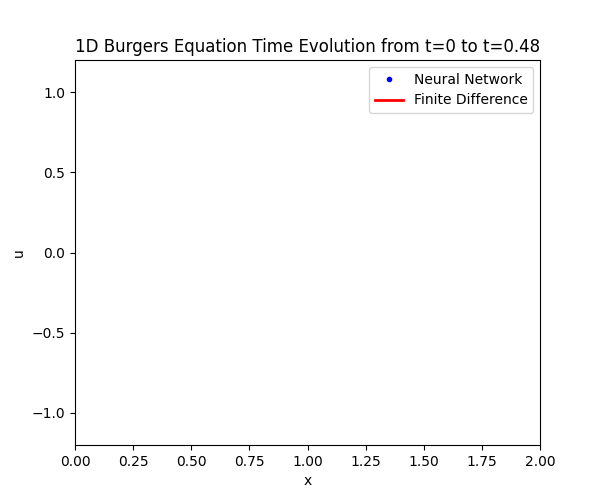

In [126]:
#Imports for animation and display within a jupyter notebook
from matplotlib import animation, rc
from IPython.display import HTML

#Generating the figure that will contain the animation
fig, ax = plt.subplots()
fig.set_dpi(100)
fig.set_size_inches(6, 5)
ax.set_xlim(( x_min, x_max))
ax.set_ylim((-1.2, 1.2))
PINN_ax, = ax.plot([], [], "bo", markersize=3,label='Neural Network')
FDM, = ax.plot([], [], "r", lw=2,label='Finite Difference')
ax.legend();
plt.xlabel('x')
plt.ylabel('u')
plt.title('1D Burgers Equation Time Evolution from t=0 to t=0.48');


In [127]:
#Initialization function for funcanimation
def init():
    FDM.set_data([], [])
    PINN_ax.set_data([], [])
    return (PINN_ax, FDM)


In [128]:
#Main animation function, each frame represents a time step in our calculation
u_NN_2D = PINN(x_test).reshape(shape=[total_points_t,total_points_x]).transpose(1,0).detach().cpu()
def animate(j):

    unn = u_NN_2D[:,j].unsqueeze(1).detach().cpu().numpy()

    ufdm = u_fem_2D[:,j].unsqueeze(1).detach().cpu().numpy()

    PINN_ax.set_data(x, unn)
    FDM.set_data(x, ufdm)

    return (PINN_ax, FDM,)

In [129]:
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=total_points_t, interval=100)
anim.save('burger_pinn_fdm_comparison_t_60.gif', writer='pillow')